In [1]:
import json
data = [json.loads(line) for line in open('/Users/blakemyers/Desktop/Project4/signalmedia-1m.jsonl', 'r')]

In [2]:
desc = []

for dic in data:
    a = dic.get(list(dic)[1])
    desc.append(a)

In [3]:
heads = []

for dic in data:
    a = dic.get(list(dic)[2])
    heads.append(a)

In [4]:
keywords = []

for i in heads:
    a = None
    keywords.append(a)

In [5]:
lisTup = (heads, desc, keywords)

In [6]:
import pickle

In [7]:
with open('tokens.pkl', 'wb') as f:
    pickle.dump(lisTup, f)

In [8]:
FN = 'vocabulary-embedding'

In [9]:
seed=42

In [10]:
vocab_size = 40000

In [11]:
embedding_dim = 100

In [12]:
lower = False # dont lower case the text

In [13]:
FN0 = '/Users/blakemyers/Desktop/Jupyter/tokens.pkl' # this is the name of the data file which I assume you already have
with open(FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [14]:
if lower:
    heads = [h.lower() for h in heads]

In [15]:
if lower:
    desc = [h.lower() for h in desc]

In [16]:
i=0
heads[i]

'Worcester breakfast club for veterans gives hunger its marching orders'

In [17]:
desc[i]

'VETERANS saluted Worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. \n \nThe Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday. \n \nThe club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. \n \nFather-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country. \n \nHe said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up. \n \n"We even had an old chap travel from Droitwich and he was late on parade by three hours. \n \n"It\'s generated a lot of interest and I estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. Onwards and upwards." \n \nHe said the management at the pub ha

In [18]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [19]:
vocab, vocabcount = get_vocab(heads+desc)

/Users/blakemyers/opt/anaconda3/envs/PythonLevenshtein/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.
/Users/blakemyers/opt/anaconda3/envs/PythonLevenshtein/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


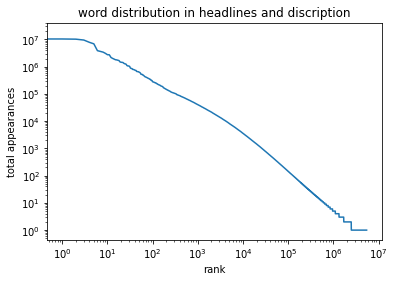

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [21]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [22]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.iteritems())

    return word2idx, idx2word

In [24]:
word2idx, idx2word = get_idx(vocab, vocabcount)

AttributeError: 'dict' object has no attribute 'iteritems'

In [ ]:
import os

In [ ]:
from keras.utils.data_utils import get_file

In [ ]:
fname = '/Users/blakemyers/Desktop/Project4/glove/glove.6B.%dd.txt'%embedding_dim
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

In [ ]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

In [ ]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [ ]:
glove_embedding_weights.std()

In [ ]:
for w,i in glove_index_dict.iteritems():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [ ]:
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print ('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print ('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

In [ ]:
glove_thr = 0.5

In [ ]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [ ]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.iteritems():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print ('# of glove substitutes found', len(glove_match))

In [ ]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

In [ ]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]

In [ ]:
with open('%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)